## Code for logit lens experiment of arithmetic task

In [1]:
import torch
from datasets import load_from_disk
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer
)
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import pickle
import random

In [2]:
# Check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Settings
model_name = "meta-llama/Llama-3.1-8B"
base = 10
layer = 9
alpha = 0.0
with_intervention = True
if with_intervention:
    input_dir = f"{model_name.split('/')[-1]}/base{base}/with_intervention/alpha_{alpha:0.2f}_layer_dofm_{layer}/"
else:
    input_dir = f"{model_name.split('/')[-1]}/base{base}/base{base}"

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
# model = AutoModelForCausalLM.from_pretrained(model_name)

# # Save the weights of the unembedding and final layer normalization
# unembed_weights = model.lm_head.weight
# final_layer_norm = model.model.norm

# os.makedirs(model_name.split('/')[-1], exist_ok=True)
# # Save the weights
# torch.save(unembed_weights, f"{model_name.split('/')[-1]}/unembed_weights.pt")
# torch.save(final_layer_norm, f"{model_name.split('/')[-1]}/final_layer_norm.pt")

In [3]:
# Function to get the probabilities over the next token given the activations.
def logit_lens(unembed_weights, final_layer_norm, activations):
    """
    Get the probabilities of the next token given the activations.
    """

    normed_h = final_layer_norm(activations)
    logits = torch.matmul(normed_h, unembed_weights.T)
    
    probs = torch.softmax(logits, dim=-1)
    
    return probs

In [4]:
def get_label(expr, base):
    lhs, rhs = expr.split("+")
    lhs_base10 = int(lhs, base)
    rhs_base10 = int(rhs, base) 
    sum_base10 = lhs_base10 + rhs_base10
    return np.base_repr(sum_base10, base)

def prepare_dataset_labels(expressions, base, tokenizer):
    """
    Load and prepare dataset labels for arithmetic expressions.
    
    Args:
        base: The number base to use for calculations
        tokenizer: Tokenizer to encode/decode labels
        
    Returns:
        List of dictionaries containing expression labels and tokens
    """
    # Load the datasets for the base and prepare the labels
    expr_labels = []
    counter = 0
    for i in range(len(expressions)):
        label = get_label(expressions[i], base)
        # Get the real world label
        token_ids = tokenizer.encode(label, add_special_tokens=False)

        # Check if expression contains any letters
        if any(c.isalpha() for c in expressions[i]):
            rw_label = None
            print("Warning: Expression contains letters")
            counter += 1
        else:
            rw_label = get_label(expressions[i], 10)
            rw_token_ids = tokenizer.encode(rw_label, add_special_tokens=False)

        item = {
            "expr": expressions[i],
            "label": label,
            "token_ids": token_ids,
            "token_str": tokenizer.decode(token_ids),
            "rw_label": rw_label,
            "rw_token_ids": rw_token_ids,
            "rw_token_str": tokenizer.decode(rw_token_ids),
        }

        expr_labels.append(item)
        
    return expr_labels

In [5]:
# Evaluate the model responses an accuracy
import hashlib
import re
import sys

import numpy as np


def unescape(str):
    placeholder = "<TMP>"
    assert placeholder not in str
    return str.replace("\\\\n", placeholder).replace("\\n", "\n").replace(placeholder, "\\n").replace("\\\\r", placeholder).replace("\\r", "\r").replace(placeholder, "\\r")


def parse_output(output):
    if len(output) == 0:
        return "FAILED"

    output_hash = hashlib.md5(output.encode("utf-8")).hexdigest()
    if output_hash in {"a7994fde4fba7d27500e6f03008abd7c"}:
        return "FAILED"

    output = output.replace(",", "").replace("С", "C")

    if (match := re.search("^[0-9A-Z]+$", output)) is not None:
        return output

    output = output.rstrip("\n$ `")
    if output.endswith("\n"):
        output = output[:-1]
    output = output.replace("\\text{", "")

    boxed_regex = r"boxed{(\\text{)?(result=)?([0-9A-Z]+(_{?[0-9]+}?)?\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)?\s*=\s*)?(0x)?([0-9A-Za-f \\.]+)(_ ?{?(base-)?([0-9]+|ten)}?)?}?(_{?([0-9]+|ten)}?)?}"
    get_result_from_boxed_regex = lambda match: match[-6].replace(" ", "").replace("\\", "")
    # match all \boxed{...} but also make sure there's only one match
    match = re.findall(boxed_regex, output)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.split("\n")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.rstrip(" .").split(".")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    if (match := re.search(r"\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*\+\s*\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*=\s*\\boxed{([0-9A-Z]+)}(_{?[0-9]+}?)?\.?$", last_line)) is not None:
        return match.groups()[-2]

    if (match := re.search(r"\\boxed{([0-9A-Z]+)_{?[0-9]+}?\s*=\s*[0-9A-Z]+_{?10}?}\$?\.?$", last_line)) is not None:
        return match.groups()[0]

    if (match := re.search(r"\$?[0-9A-Z]+(_{?[0-9]+}?)\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)\s*=\s*(0x)?([0-9A-Z]+)(_{?[0-9]+}?)\$?( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-3]

    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?,?( and| or| =) \$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?\.?$", output)) is not None:
        return match.groups()[2]
    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?,?( and| or| =) \$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?\.?$", output)) is not None:
        return match.groups()[-1]
    # \boxed{207}_{10}$ which in base-11 is $\boxed{18A}$.
    if (match := re.search(r"\\boxed{[0-9A-Z]+}_\{10\}\$? which in base-[0-9]+ is \$?\\boxed{(0x)?([0-9A-Z]+)}\$?\.?$", output)) is not None:
        return match.groups()[-1]
    # 39 + 31 = 5A\boxed{}
    if (match := re.search(r"[0-9]+\s*\+\s*[0-9]+\s*=\s*([0-9A-Z]+)\\boxed\{\}\.?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result}\n62
    if (match := re.search(r"\\boxed{result}\s*(\n|=)?\s*([0-9A-Z+*^. ]+=\s*)?([0-9A-Z.]+)\$?\.?\**}?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result: 62}
    if (match := re.search(r"\\boxed{result: ([0-9A-Z]+)}$", output)) is not None:
        return match.groups()[0]

    match = re.findall(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*(0x)?([0-9A-Z]+)", last_line)
    if len(match) == 1:
        return match[0][1]

    match_after_semicolon = r"\s+((\n|[ 0-9A-Z*^])+(\+(\n|[ 0-9A-Z*^])+)+(=|-+|_+)\s*)*([0-9A-Z]+)\s*(\(?(in )?base-[0-9]+\)?)?(, which [^,.]+)?(\s*\([^()]+\))?\.?$"
    if (match := re.search(r"\n([0-9A-Z]+)$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z]+)\"?( base-[0-9]+)?(, (or|since) [^.]+)?( \([^()]+\))?\.$", output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r" in base-[0-9]+: \$?([0-9A-Z]+)\$?\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" the base-[0-9]+ sum: ([0-9A-Z]+)\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result in base-[0-9]+ is ([0-9A-Z]+), which is equal to [0-9 *^+()]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"the sum of [0-9A-Z]+ and [0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"the result of [0-9A-Z]+\s*\+\s*[0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+( in base-[0-9]+)?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"in base-10 is \$?[0-9]+\$?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*([0-9A-Z]+)( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"we can simply write the result as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"which can be written as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"(which gives|giving) us the( base-[0-9]+)? number ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the final result is simply the sum of the tens and ones places: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result is simply the combination of these two sums: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"we have ([0-9A-Z]+) in base-[0-9]+ as the (final answer for|result of|sum of) [0-9A-Z]+ (\+|and) [0-9A-Z]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"we (have|get|end up with) ([0-9A-Z]+)( in base-[0-9]+)? as the( final)? (result|answer|sum)( in base-[0-9]+)?\.$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"(=| is) \"?([0-9A-Z]+)\"?\s*(\s+\(?(in )?base-[0-9]+\)?)?\.?$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"( final)?( base-[0-9]+)? (result|answer|sum)( in base-[0-9]+)?( is)?( simply)?( of)?( as)?:?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we get:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we can add the two numbers in base-[0-9]+:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[tT]he combination of these sums:\s+([0-9A-Z]+)(\(in base-[0-9]+\))?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"(Result|Answer)( is)?:?\s+([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"The decimal equivalent of \$?([0-9A-Z]+)\$? is therefore \$?[0-9A-Z]+\$?\.?$", output)) is not None:
        return match.groups()[0]
    if (match := re.search(r"(T|t)he final (result|answer) is:?\s+([0-9A-Z ]+\s*\+\s*[0-9A-Z ]+\s*(=|-+)+\s*)?([0-9A-Z ]+)(\(in base-[0-9]+\))?\.?\**$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z ]+)\"?(, or [^,.]+)?\.$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r"( |(\n))([0-9A-Z]+) \(?in base-[0-9]+\)?\.$", output)) is not None:
        return match.groups()[-1]

    #print("Failed to parse output:", output)
    #print(output_hash)
    return "FAILED"

In [7]:
# from datasets import load_from_disk
# # Load from disk
# base = 8
# dataset = load_from_disk(f"../../../../results/arithmetic/probe/llama3_base/base{base}")
# activations = dataset["residual_activations"]
# # Save expressions and LLM responses to a file
# expressions = dataset["expr"]
# llm_responses = dataset["llm_response"]

# output_dir = f"{model_name.split('/')[-1]}/"

# # save  the expressions and llm responses to disk
# with open(f"{output_dir}/expressions.pkl", "wb") as f:
#     pickle.dump(expressions, f)
# with open(f"{output_dir}/llm_responses.pkl", "wb") as f:
#     pickle.dump(llm_responses, f)



In [6]:
# Get the LLM responses:
llm_responses = pickle.load(open(f"{input_dir}/llm_responses_base{base}.pkl", "rb"))
expressions = pickle.load(open(f"{input_dir}/expressions_base{base}.pkl", "rb"))

wrong_answer_mask = torch.zeros(len(llm_responses), dtype=torch.bool)
correct_answer_mask = torch.zeros(len(llm_responses), dtype=torch.bool)
real_world_answer_mask = torch.zeros(len(llm_responses), dtype=torch.bool)
count = 0
for i in range(len(llm_responses)):
    try:
        correct_response = get_label(expressions[i], base)
        real_world_response = get_label(expressions[i], 10)
        
        llm_response = llm_responses[i].split("=")[1].strip()
        llm_response = llm_response.split("\n")[0].strip()
        pred = parse_output(llm_response).upper()
        if pred == correct_response:
            correct_answer_mask[i] = True
        elif pred == real_world_response:
            real_world_answer_mask[i] = True
        else:
            wrong_answer_mask[i] = True
    except Exception as e:
        print(llm_responses[i])


print(wrong_answer_mask.sum())
print(correct_answer_mask.sum())
print(real_world_answer_mask.sum())

print(count)

tensor(1)
tensor(999)
tensor(0)
0


In [9]:
# # # Create the correct structure from the activations loaded from disk
# layer_activation_dict={i: torch.zeros(len(activations), 4096) for i in range(32)}
# for i in range(len(activations)):
#     for j in range(32):
#         layer_activation_dict[j][i] = torch.tensor(activations[i][j])

In [10]:
# # Process the activations for each layer and all instances and save -- takes around 6-7 minutes
# results = {}
# layer_probs = {_ : torch.zeros(len(activations), 1000) for _ in range(32)}
# correct_token_ids = []

# # Load the unembedding weights and final layer normalization for logit lens
# unembed_weights = torch.load(f"{model_name.split('/')[-1]}/unembed_weights.pt", weights_only=True)
# final_layer_norm = torch.load(f"{model_name.split('/')[-1]}/final_layer_norm.pt", weights_only=False)

# expr_labels = prepare_dataset_labels(expressions, base, tokenizer)
# rw_token_ids = torch.tensor([label["rw_token_ids"][0] for label in expr_labels])
# token_ids = torch.tensor([label["token_ids"][0] for label in expr_labels])


# for layer in range(32):
#     print(f"Processing layer {layer}...")
#     layer_activations = layer_activation_dict[layer]
#     with torch.no_grad():
#         probs = logit_lens(unembed_weights, final_layer_norm, layer_activations)
#     layer_probs[layer] = probs.cpu()
#     if device == "cuda":
#         probs.cpu()

#     # Get the probabilities for the correct token
#     batch_indices = torch.arange(len(expr_labels))
#     correct_token_probs = probs[batch_indices, token_ids]
#     rw_token_probs = probs[batch_indices, rw_token_ids]

#     results[layer] = {
#         "correct_token_probs": correct_token_probs.tolist(),
#         "rw_token_probs": rw_token_probs.tolist(),
#         "probs": probs.tolist()
#     }
#     del probs


### Code to generate a pkl object for the logit lens probabilities/logits 

In [11]:
# # Save the results
# import pickle
# # Using pickle since it can efficiently serialize complex Python objects like nested dictionaries
# # containing numpy arrays and torch tensors, while maintaining their structure and data types
# with open(f"{model_name.split('/')[-1]}/logit_lens_results_base{base}.pkl", "wb") as f:
#     pickle.dump(layer_probs, f)


In [7]:
loaded_layer_probs = pickle.load(open(f"{input_dir}/logit_lens_results_base{base}.pkl", "rb"))
results = {}
expr_labels = prepare_dataset_labels(expressions, base, tokenizer)
rw_token_ids = torch.tensor([label["rw_token_ids"][0] for label in expr_labels])
token_ids = torch.tensor([label["token_ids"][0] for label in expr_labels])
for layer in range(32):
    batch_indices = torch.arange(len(expr_labels))

    correct_token_probs = loaded_layer_probs[layer][batch_indices, token_ids]
    rw_token_probs = loaded_layer_probs[layer][batch_indices, rw_token_ids]
    results[layer] = {
        "correct_token_probs": correct_token_probs.tolist(),
        "rw_token_probs": rw_token_probs.tolist(),
    }


In [13]:
# # Assuming `tokenizer` and `loaded_layer_probs` are already defined

# # Prepare neighborhood token IDs for all tokens
# all_neighbor_token_ids = []

# for token_id in token_ids:
#     digit = int(tokenizer.decode(token_id.item()))
#     neighbor_token_ids = []
    
#     for i in range(1, 10):  # Adjust range as needed
#         neighbor_token_ids.append(tokenizer.encode(str(digit + i), add_special_tokens=False)[0])
#         neighbor_token_ids.append(tokenizer.encode(str(digit - i), add_special_tokens=False)[0])
    
#     all_neighbor_token_ids.append(neighbor_token_ids)

# # Convert to tensor
# all_neighbor_token_ids = torch.tensor(all_neighbor_token_ids)

# # Retrieve probabilities for each layer in batches
# neighborhood_probs = {}

# for layer in range(32):
#     # Get probabilities for all neighborhood tokens
#     neighbor_probs = loaded_layer_probs[layer][:, all_neighbor_token_ids.flatten()]
    
#     # Reshape to match the original structure
#     neighbor_probs = neighbor_probs.view(len(token_ids), -1, neighbor_probs.size(1))
    
#     # Store mean probabilities
#     neighborhood_probs[layer] = neighbor_probs.mean(dim=1).tolist()

# # Plot the average neighborhood probs for each layer
# for layer in range(32):
#     plt.plot(range(len(token_ids)), np.mean(neighborhood_probs[layer], axis=0), label=f'Layer {layer}')
# plt.legend()
# plt.show()


In [8]:
corr_ans_correct_token_probs = {layer: [] for layer in range(32)}
other_ans_correct_token_probs = {layer: [] for layer in range(32)}
rw_ans_correct_token_probs = {layer: [] for layer in range(32)}
corr_ans_rw_token_probs = {layer: [] for layer in range(32)}
other_ans_rw_token_probs = {layer: [] for layer in range(32)}
rw_ans_rw_token_probs = {layer: [] for layer in range(32)}
for layer in range(32):
    correct_mask = correct_answer_mask
    incorrect_mask = ~correct_answer_mask
    layer_correct_probs = results[layer]["correct_token_probs"]
    layer_rw_probs = results[layer]["rw_token_probs"]
    
    corr_ans_correct_token_probs[layer] = [p for i, p in enumerate(layer_correct_probs) if correct_mask[i]]
    rw_ans_correct_token_probs[layer] = [p for i, p in enumerate(layer_correct_probs) if real_world_answer_mask[i]]
    other_ans_correct_token_probs[layer] = [p for i, p in enumerate(layer_correct_probs) if incorrect_mask[i]]

    corr_ans_rw_token_probs[layer] = [p for i, p in enumerate(layer_rw_probs) if correct_mask[i]]
    rw_ans_rw_token_probs[layer] = [p for i, p in enumerate(layer_rw_probs) if real_world_answer_mask[i]]
    other_ans_rw_token_probs[layer] = [p for i, p in enumerate(layer_rw_probs) if incorrect_mask[i]]

print(len(corr_ans_correct_token_probs[0]))
print(np.mean(corr_ans_correct_token_probs[30]))
print(np.mean(corr_ans_rw_token_probs[30]))

# instance_idx = random.randint(0, len(results[31]["correct_token_probs"]) - 1)
# probs = results[31]["probs"][instance_idx, :]  # Get probabilities from first (and only) batch
# print(probs.shape)
# max_prob, max_idx = torch.max(probs, dim=0)
# print(f"Max probability: {max_prob.item():.4f} at index {max_idx.item()}")

# print(tokenizer.decode(max_idx.item()))
# print(get_label(expr_labels[instance_idx]["expr"], 10))
# print(get_label(expr_labels[instance_idx]["expr"], base))
# #Plot the correct token probs over layers


999
0.9781232225047695
0.9781232225047695


/gpfs/home5/jholshuijsen/reasoning-reciting-probing/.venv/lib64/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/home5/jholshuijsen/reasoning-reciting-probing/.venv/lib64/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


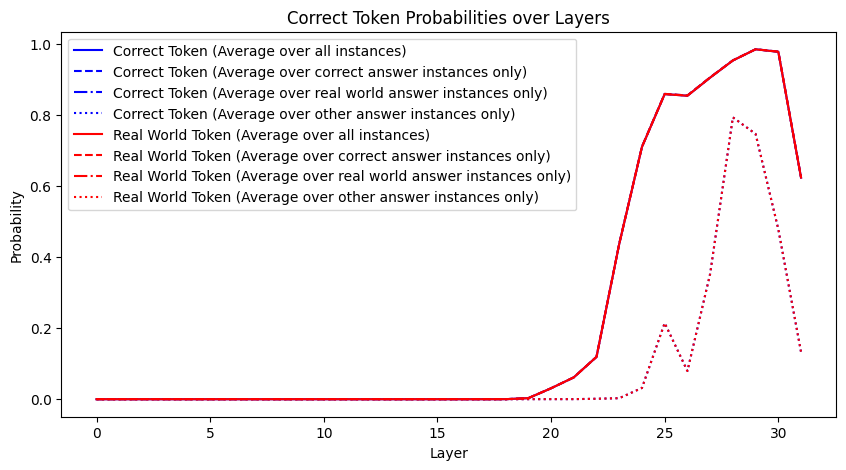

In [9]:
corr_ans_correct_token_probs = [np.mean(corr_ans_correct_token_probs[layer]) for layer in range(32)]
corr_ans_rw_token_probs = [np.mean(corr_ans_rw_token_probs[layer]) for layer in range(32)]
other_ans_correct_token_probs = [np.mean(other_ans_correct_token_probs[layer]) for layer in range(32)]
other_ans_rw_token_probs = [np.mean(other_ans_rw_token_probs[layer]) for layer in range(32)]
rw_ans_correct_token_probs = [np.mean(rw_ans_correct_token_probs[layer]) for layer in range(32)]
rw_ans_rw_token_probs = [np.mean(rw_ans_rw_token_probs[layer]) for layer in range(32)]
corr_token_probs_across_all_instances = [np.mean(results[layer]["correct_token_probs"]) for layer in range(32)]
rw_token_probs_across_all_instances = [np.mean(results[layer]["rw_token_probs"]) for layer in range(32)]
plt.figure(figsize=(10, 5))
plt.plot(range(32), corr_token_probs_across_all_instances, color='blue', linestyle='-')
plt.plot(range(32), corr_ans_correct_token_probs, color='blue', linestyle='--')
plt.plot(range(32), rw_ans_correct_token_probs, color='blue', linestyle='-.')
plt.plot(range(32), other_ans_correct_token_probs, color='blue', linestyle=':')

plt.plot(range(32), rw_token_probs_across_all_instances, color='red', linestyle='-')
plt.plot(range(32), corr_ans_rw_token_probs, color='red', linestyle='--')
plt.plot(range(32), rw_ans_rw_token_probs, color='red', linestyle='-.')
plt.plot(range(32), other_ans_rw_token_probs, color='red', linestyle=':')
plt.xlabel('Layer')
plt.ylabel('Probability')
plt.legend(['Correct Token (Average over all instances)', 
           'Correct Token (Average over correct answer instances only)', 
           'Correct Token (Average over real world answer instances only)',
           'Correct Token (Average over other answer instances only)',
           'Real World Token (Average over all instances)', 
           'Real World Token (Average over correct answer instances only)', 
           'Real World Token (Average over real world answer instances only)',
           'Real World Token (Average over other answer instances only)'])
plt.title('Correct Token Probabilities over Layers')
plt.show()

In [16]:
batch_size = 256  # Adjust as needed for your memory
digit_token_indices = torch.tensor([tokenizer.encode(str(i), add_special_tokens=False)[0] for i in range(1000)])

correct_token_ranks_per_layer = []
real_world_token_ranks_per_layer = []
correct_ans_correct_token_ranks_per_layer = []
incorrect_ans_correct_token_ranks_per_layer = []
correct_ans_real_world_token_ranks_per_layer = []
incorrect_ans_real_world_token_ranks_per_layer = []

digit_token_to_position = {token_id.item(): i for i, token_id in enumerate(digit_token_indices)}
# Shape: (num_instances) - each instance has index of the correct token
# Map the correct token index to the digit token index
# Create a matrix that is 1 at the position of the correct token at that instance
correct_token_id_indices = torch.tensor([digit_token_to_position[tid.item()] for tid in token_ids])
real_world_token_id_indices = torch.tensor([digit_token_to_position[tid.item()] for tid in rw_token_ids])

#         # Calculate mean probability only for correct predictions
        
#         layer_mean_rw = torch.tensor(layer_probs['rw_token_probs'])[correct_mask.bool()].mean().item()
#         rw_probs.append(layer_mean_rw)
layer_ranks = {i : [] for i in range(32)}
for layer in range(32):
    print(f"Processing layer {layer}...")
    # Shape: (num_instances, token_vocab_size)
    token_distributions = loaded_layer_probs[layer]
    # Map the token distribution to only include the digit token indices
    digit_token_distributions = token_distributions[:, digit_token_indices]
    # Convert this matrix's values from probabilities to ranks
    # Get ranks by sorting
    _, ranks = torch.sort(digit_token_distributions, descending=True)
    digit_token_ranks = torch.argsort(ranks, dim=1) + 1 
    # Shape: (num_instances, 1000)

    corr_ans_digit_token_ranks = digit_token_ranks[correct_answer_mask]
    # Shape: (num_correct_instances, 1000)
    incorrect_ans_digit_token_ranks = digit_token_ranks[~correct_answer_mask]
    # Shape: (num_incorrect_instances, 1000)
    # Print the average rank of the correct token id across all instances for this layer
    total_correct_token_ranks = digit_token_ranks.gather(1, correct_token_id_indices.unsqueeze(1)).squeeze(1)
    corr_ans_correct_token_ranks = total_correct_token_ranks[correct_answer_mask]
    incorrect_ans_correct_token_ranks = total_correct_token_ranks[~correct_answer_mask]

    total_real_world_token_ranks = digit_token_ranks.gather(1, real_world_token_id_indices.unsqueeze(1)).squeeze(1)
    corr_ans_real_world_token_ranks = total_real_world_token_ranks[correct_answer_mask]
    incorrect_ans_real_world_token_ranks = total_real_world_token_ranks[~correct_answer_mask]

    # Save as tuple and add to list
    layer_ranks[layer].append({
        "correct_token_rank_all_instances": total_correct_token_ranks,
        "correct_token_rank_correct_instances": corr_ans_correct_token_ranks,
        "correct_token_rank_incorrect_instances": incorrect_ans_correct_token_ranks,
        "real_world_token_rank_all_instances": total_real_world_token_ranks,
        "real_world_token_rank_correct_instances": corr_ans_real_world_token_ranks,
        "real_world_token_rank_incorrect_instances": incorrect_ans_real_world_token_ranks,
        "ranks_all_instances": digit_token_ranks,
        "ranks_correct_instances": corr_ans_digit_token_ranks,
        "ranks_incorrect_instances": incorrect_ans_digit_token_ranks
    })
    

    


Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...
Processing layer 13...
Processing layer 14...
Processing layer 15...
Processing layer 16...
Processing layer 17...
Processing layer 18...
Processing layer 19...
Processing layer 20...
Processing layer 21...
Processing layer 22...
Processing layer 23...
Processing layer 24...
Processing layer 25...
Processing layer 26...
Processing layer 27...
Processing layer 28...
Processing layer 29...
Processing layer 30...
Processing layer 31...


In [17]:
# # Plot the average rank of the correct token per layer
# correct_token_ranks_per_layer = []
# real_world_token_ranks_per_layer = []
# correct_ans_correct_token_ranks_per_layer = []
# incorrect_ans_correct_token_ranks_per_layer = []
# correct_ans_real_world_token_ranks_per_layer = []
# incorrect_ans_real_world_token_ranks_per_layer = []

# for layer in range(32):
#     print(f"Processing layer {layer}...")
#     token_distributions = layer_probs[layer]

#     correct_token_idxs = token_ids
#     real_world_token_idxs = rw_token_ids
 
#     # Find the rank of each correct token across all instances and get the average rank for this layer
#     correct_token_probs = token_distributions[torch.arange(token_distributions.shape[0]), correct_token_idxs]
#     real_world_token_probs = token_distributions[torch.arange(token_distributions.shape[0]), real_world_token_idxs]
#     correct_token_ranks = (token_distributions > correct_token_probs.unsqueeze(1)).sum(dim=1) + 1
#     real_world_token_ranks = (token_distributions > real_world_token_probs.unsqueeze(1)).sum(dim=1) + 1

#     correct_ans_correct_token_ranks = correct_token_ranks[correct_answer_mask]
#     incorrect_ans_correct_token_ranks = correct_token_ranks[~correct_answer_mask]

#     correct_ans_real_world_token_ranks = real_world_token_ranks[correct_answer_mask]
#     incorrect_ans_real_world_token_ranks = real_world_token_ranks[~correct_answer_mask]

#     correct_token_ranks_per_layer.append(correct_token_ranks.float().mean().item())
#     correct_ans_correct_token_ranks_per_layer.append(correct_ans_correct_token_ranks.float().mean().item())
#     incorrect_ans_correct_token_ranks_per_layer.append(incorrect_ans_correct_token_ranks.float().mean().item())

#     real_world_token_ranks_per_layer.append(real_world_token_ranks.float().mean().item())
#     correct_ans_real_world_token_ranks_per_layer.append(correct_ans_real_world_token_ranks.float().mean().item())
#     incorrect_ans_real_world_token_ranks_per_layer.append(incorrect_ans_real_world_token_ranks.float().mean().item())



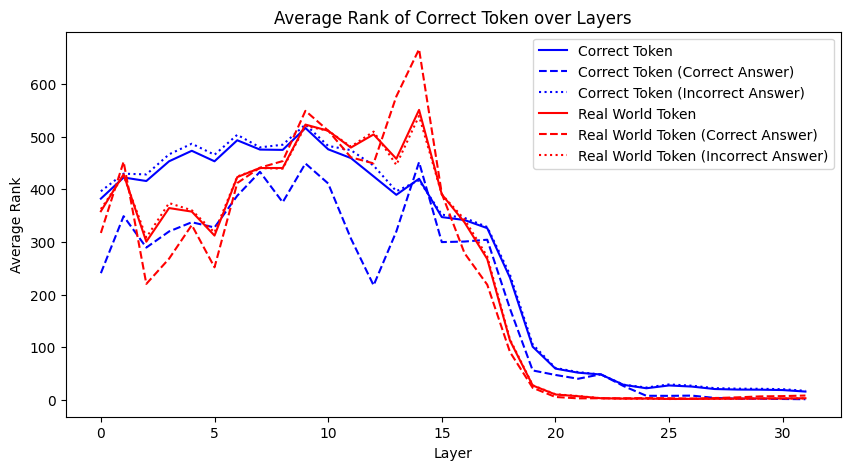

In [18]:
start_layer = 0

# Split ranks into correct and incorrect instances


# print(correct_token_ranks_per_layer[31])
# print(real_world_token_ranks_per_layer[31])


plt.figure(figsize=(10, 5))
plt.plot(range(start_layer, 32), [layer_ranks[i][0]["correct_token_rank_all_instances"].float().mean().item() for i in range(start_layer, 32)], color='blue')
plt.plot(range(start_layer, 32), [layer_ranks[i][0]["correct_token_rank_correct_instances"].float().mean().item() for i in range(start_layer, 32)], linestyle='--', color='blue')
plt.plot(range(start_layer, 32), [layer_ranks[i][0]["correct_token_rank_incorrect_instances"].float().mean().item() for i in range(start_layer, 32)], linestyle=':', color='blue')
plt.plot(range(start_layer, 32), [layer_ranks[i][0]["real_world_token_rank_all_instances"].float().mean().item() for i in range(start_layer, 32)], color='red')
plt.plot(range(start_layer, 32), [layer_ranks[i][0]["real_world_token_rank_correct_instances"].float().mean().item() for i in range(start_layer, 32)], linestyle='--', color='red')
plt.plot(range(start_layer, 32), [layer_ranks[i][0]["real_world_token_rank_incorrect_instances"].float().mean().item() for i in range(start_layer, 32)], linestyle=':', color='red')
plt.xlabel('Layer')
plt.ylabel('Average Rank')
plt.title('Average Rank of Correct Token over Layers')
plt.legend(['Correct Token', 'Correct Token (Correct Answer)', 'Correct Token (Incorrect Answer)', 'Real World Token', 'Real World Token (Correct Answer)', 'Real World Token (Incorrect Answer)'])
plt.show()

In [19]:
# Get the tokens and their counts of occuring in the top 30 ranks
instance_idx = 7

ranks_of_layer = layer_ranks[31][0]["ranks_all_instances"]

# For instance 0, get the top 30 ranks, print the first rank and print the correct and real world token rank
top_k_values, top_k_indices = torch.topk(ranks_of_layer[instance_idx], k=30, largest=False, sorted=True)

# Map the indices back to the original token IDs using digit_token_indices
top_k_token_ids = digit_token_indices[top_k_indices]

print("Top 30 token IDs:", top_k_token_ids)
# Decode the tokens
top_k_token_ids_decoded = [tokenizer.decode(token_id.item()) for token_id in top_k_token_ids]
print("Top 30 token IDs decoded:", top_k_token_ids_decoded)
print("Correct token ID:", tokenizer.decode(token_ids[instance_idx].item()))
print("Real world token ID:", tokenizer.decode(rw_token_ids[instance_idx].item()))
print("Top 30 token ranks:", top_k_values)


Top 30 token IDs: tensor([ 8027,   845,    16,  7322,  8546,  1041,    22,  9390,    21,   806,
         5037,    17,  5120,  9795,  8011,    18, 12463,  4645,    23,    20,
         4364,  2287,  4767,   605, 17763,  8874,    19, 10465,  7461,  4161])
Top 30 token IDs decoded: ['116', '16', '1', '115', '117', '100', '7', '126', '6', '11', '111', '2', '110', '136', '114', '3', '216', '101', '8', '5', '120', '66', '76', '10', '416', '124', '4', '146', '106', '96']
Correct token ID: 136
Real world token ID: 116
Top 30 token ranks: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])


Mean difference between correct and real world answer labels: 17.912000000000006
Mean difference for correctly answered instances: 10.644444444444446
Mean difference for incorrectly answered instances: 18.630769230769218
Count of instances where the difference between the correct and real world answer labels is more or equal to 20: 839


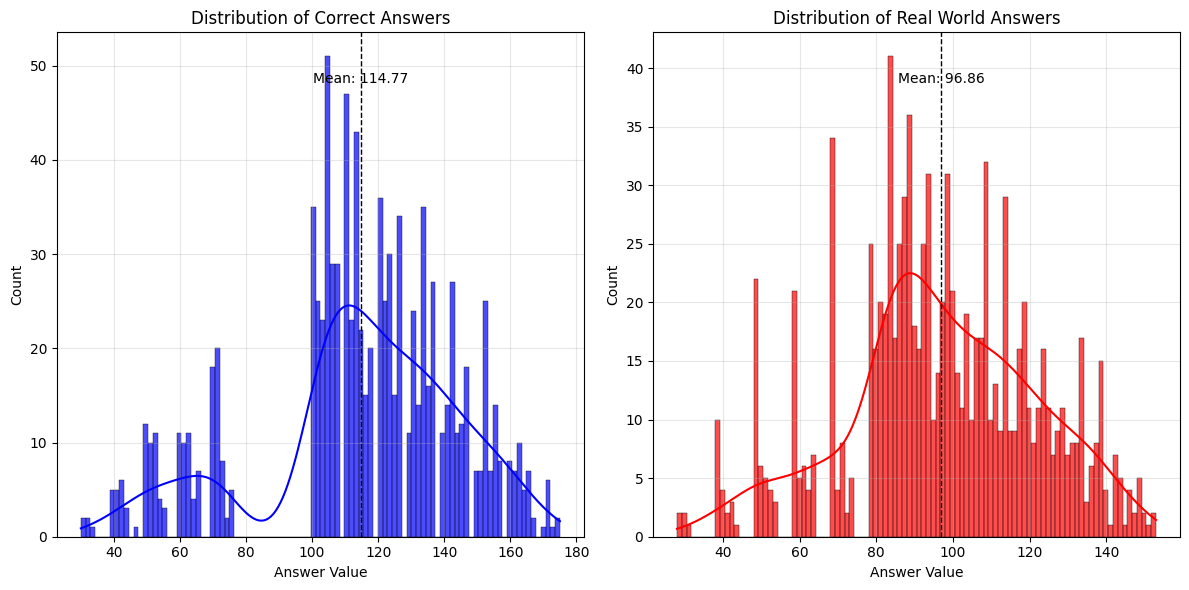

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the real world and correct answer labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

correct_answer_labels = [int(expr_labels[i]['label']) for i in range(len(expr_labels))]
real_world_answer_labels = [int(expr_labels[i]['rw_label']) for i in range(len(expr_labels))]
# Print the count when the difference between the correct and real world answer labels is more or equal to 20
# What is the mean difference between the correct and real world answer labels?
print(f"Mean difference between correct and real world answer labels: {np.mean(correct_answer_labels) - np.mean(real_world_answer_labels)}")

# Assuming correct_answer_labels, real_world_answer_labels, and correct_answer_mask are defined

# Filter the labels for instances where the model answered correctly

filtered_correct_labels = []
filtered_correct_real_world_labels = []
for i in range(len(correct_answer_labels)):
    if correct_answer_mask[i]:
        filtered_correct_labels.append(correct_answer_labels[i])
        filtered_correct_real_world_labels.append(real_world_answer_labels[i])

# Print the mean difference for the correctly answered instances
mean_difference = np.mean(filtered_correct_labels) - np.mean(filtered_correct_real_world_labels)
print(f"Mean difference for correctly answered instances: {mean_difference}")

filtered_incorrect_labels = []
filtered_incorrect_real_world_labels = []
for i in range(len(correct_answer_labels)):
    if not correct_answer_mask[i]:
        filtered_incorrect_labels.append(correct_answer_labels[i])
        filtered_incorrect_real_world_labels.append(real_world_answer_labels[i])


mean_difference = np.mean(filtered_incorrect_labels) - np.mean(filtered_incorrect_real_world_labels)

print(f"Mean difference for incorrectly answered instances: {mean_difference}")

# Print the count of instances where the difference between the correct and real world answer labels is more or equal to 20
count = 0
for i in range(len(correct_answer_labels)):
    if np.abs(correct_answer_labels[i] - real_world_answer_labels[i]) >= 20:
        count += 1

print(f"Count of instances where the difference between the correct and real world answer labels is more or equal to 20: {count}")


# Is there a large variance in the difference?

# Plot correct answers distribution with KDE
sns.histplot(correct_answer_labels, bins=100, color='blue', alpha=0.7, kde=True, ax=ax1)
ax1.set_xlabel('Answer Value')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Correct Answers')
ax1.grid(True, alpha=0.3)

# Calculate and plot mean for correct answers
mean_correct = np.mean(correct_answer_labels)
ax1.axvline(mean_correct, color='k', linestyle='dashed', linewidth=1)
ax1.text(mean_correct, ax1.get_ylim()[1] * 0.9, f'Mean: {mean_correct:.2f}', color='black', ha='center')



# Plot real world answers distribution with KDE
sns.histplot(real_world_answer_labels, bins=100, color='red', alpha=0.7, kde=True, ax=ax2)
ax2.set_xlabel('Answer Value')
ax2.set_ylabel('Count') 
ax2.set_title('Distribution of Real World Answers')
ax2.grid(True, alpha=0.3)

# Calculate and plot mean for real world answers
mean_real_world = np.mean(real_world_answer_labels)
ax2.axvline(mean_real_world, color='k', linestyle='dashed', linewidth=1)
ax2.text(mean_real_world, ax2.get_ylim()[1] * 0.9, f'Mean: {mean_real_world:.2f}', color='black', ha='center')




plt.tight_layout()
plt.show()

Processing layer 0...
Mean digit value of the top 20 digits for correct instances: 362.95
Mean digit value of the top 20 digits for incorrect instances: 340.75
Diff in means for correct and incorrect instances: 22.20
Processing layer 1...
Mean digit value of the top 20 digits for correct instances: 379.40
Mean digit value of the top 20 digits for incorrect instances: 379.40
Diff in means for correct and incorrect instances: 0.00
Processing layer 2...
Mean digit value of the top 20 digits for correct instances: 398.20
Mean digit value of the top 20 digits for incorrect instances: 391.30
Diff in means for correct and incorrect instances: 6.90
Processing layer 3...
Mean digit value of the top 20 digits for correct instances: 476.85
Mean digit value of the top 20 digits for incorrect instances: 476.85
Diff in means for correct and incorrect instances: 0.00
Processing layer 4...
Mean digit value of the top 20 digits for correct instances: 331.75
Mean digit value of the top 20 digits for inc

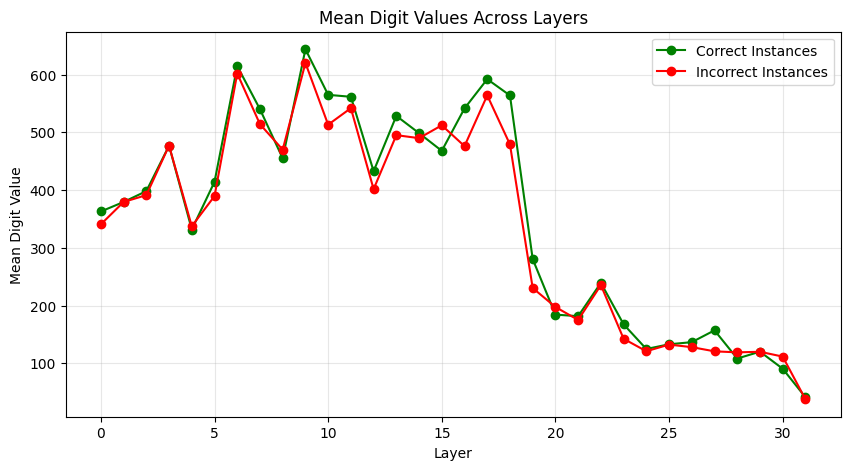

In [59]:
# Initialize a dictionary to store rank sums and counts for each token
# Get the average rank for across all instances for each token for layer 31
mean_correct_digits = []
mean_incorrect_digits = []

for layer in range(32):
    print(f"Processing layer {layer}...")
    layer_ranks_all = layer_ranks[layer][0]["ranks_all_instances"]
    layer_ranks_correct = layer_ranks[layer][0]["ranks_correct_instances"]
    layer_ranks_incorrect = layer_ranks[layer][0]["ranks_incorrect_instances"]

    # Get the average rank across all instances (dim 0) for each token (dim 1)
    layer_avg_ranks_all = layer_ranks_all.float().mean(dim=0)
    layer_avg_ranks_correct = layer_ranks_correct.float().mean(dim=0)
    layer_avg_ranks_incorrect = layer_ranks_incorrect.float().mean(dim=0)

    # Sort the average ranks, but keep track of the original index
    layer_avg_ranks_all_sorted, layer_avg_ranks_all_indices = torch.sort(layer_avg_ranks_all, dim=-1, descending=False)
    layer_avg_ranks_correct_sorted, layer_avg_ranks_correct_indices = torch.sort(layer_avg_ranks_correct, dim=-1, descending=False)
    layer_avg_ranks_incorrect_sorted, layer_avg_ranks_incorrect_indices = torch.sort(layer_avg_ranks_incorrect, dim=-1, descending=False)

    # Get the top 20 indices for each category
    top = 20
    top_30_all_indices = layer_avg_ranks_all_indices[:top]
    top_30_correct_indices = layer_avg_ranks_correct_indices[:top]
    top_30_incorrect_indices = layer_avg_ranks_incorrect_indices[:top]

    # Decode the digits and get their average ranks
    top_30_all_digits = [int(tokenizer.decode(digit_token_indices[idx])) for idx in top_30_all_indices]
    top_30_all_ranks = [layer_avg_ranks_all_sorted[i].item() for i in range(top)]
    top_30_correct_digits = [int(tokenizer.decode(digit_token_indices[idx])) for idx in top_30_correct_indices]
    top_30_correct_ranks = [layer_avg_ranks_correct_sorted[i].item() for i in range(top)]
    top_30_incorrect_digits = [int(tokenizer.decode(digit_token_indices[idx])) for idx in top_30_incorrect_indices]
    top_30_incorrect_ranks = [layer_avg_ranks_incorrect_sorted[i].item() for i in range(top)]

    # Store mean digits for plotting
    mean_correct_digits.append(np.mean(top_30_correct_digits))
    mean_incorrect_digits.append(np.mean(top_30_incorrect_digits))

    # Print statistics
    print(f"Mean digit value of the top {top} digits for correct instances: {mean_correct_digits[-1]:.2f}")
    print(f"Mean digit value of the top {top} digits for incorrect instances: {mean_incorrect_digits[-1]:.2f}")
    print(f"Diff in means for correct and incorrect instances: {mean_correct_digits[-1] - mean_incorrect_digits[-1]:.2f}")

# Plot the means across layers
plt.figure(figsize=(10, 5))
plt.plot(range(32), mean_correct_digits, label='Correct Instances', color='green', marker='o')
plt.plot(range(32), mean_incorrect_digits, label='Incorrect Instances', color='red', marker='o')
plt.xlabel('Layer')
plt.ylabel('Mean Digit Value')
plt.title('Mean Digit Values Across Layers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

    # Create figure with 2 subplots
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # # Plot correct instances in first subplot
    # ax1.bar(top_30_correct_digits, top_30_correct_ranks, color='green', alpha=0.3, edgecolor='green', label='Correct Instances')
    # ax1.set_title('Top Digits - Correct Instances')
    # ax1.set_xlabel('Digit')
    # ax1.set_ylabel('Average Rank')
    # ax1.set_xlim(min_digit - 1, max_digit + 1)
    # ax1.invert_yaxis()  # Lower rank (better) should be at the top
    # ax1.legend()
    # unique_digits_correct = sorted(set(top_30_correct_digits))
    # ax1.set_xticks(unique_digits_correct)

    # # Plot incorrect instances in second subplot
    # ax2.bar(top_30_incorrect_digits, top_30_incorrect_ranks, color='red', alpha=0.3, edgecolor='red', label='Incorrect Instances')
    # ax2.set_title('Top Digits - Incorrect Instances')
    # ax2.set_xlabel('Digit')
    # ax2.set_ylabel('Average Rank')
    # ax2.set_xlim(min_digit - 1, max_digit + 1)
    # ax2.invert_yaxis()  # Lower rank (better) should be at the top
    # ax2.legend()
    # unique_digits_incorrect = sorted(set(top_30_incorrect_digits))
    # ax2.set_xticks(unique_digits_incorrect)

    # plt.tight_layout()
    # plt.show()

        # Plot the histograms
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # # Plot for correct instances
    # ax1.barh(range(len(top_30_correct_digits)), top_30_correct_ranks, color='green', alpha=0.7, edgecolor='black')
    # ax1.set_title('Top Digits - Correct Instances')
    # ax1.set_xlabel('Average Rank')
    # ax1.set_ylabel('Digit')
    # ax1.set_yticks(range(len(top_30_correct_digits)))
    # ax1.set_yticklabels(top_30_correct_digits)
    # ax1.invert_xaxis()  # Lower rank (better) should be on the right

    # # Plot for incorrect instances 
    # ax2.barh(range(len(top_30_incorrect_digits)), top_30_incorrect_ranks, color='red', alpha=0.7, edgecolor='black')
    # ax2.set_title('Top Digits - Incorrect Instances')
    # ax2.set_xlabel('Average Rank')
    # ax2.set_ylabel('Digit')
    # ax2.set_yticks(range(len(top_30_incorrect_digits)))
    # ax2.set_yticklabels(top_30_incorrect_digits)
    # ax2.invert_xaxis()

    # plt.tight_layout()
    # plt.show()

# # Print the top 10 tokens with the lowest average rank
# print("Top 10 tokens with lowest average rank:")    
# for i in range(30):
#     print("--------------------------------")
#     print(f"Digit {tokenizer.decode(digit_token_indices[layer_avg_ranks_all_indices[i].item()])}: average rank {layer_avg_ranks_all_sorted[i].item():.2f}" + "|" + f"Digit {tokenizer.decode(digit_token_indices[layer_avg_ranks_correct_indices[i].item()])}: average rank {layer_avg_ranks_correct_sorted[i].item():.2f}" + "|" + f"Digit {tokenizer.decode(digit_token_indices[layer_avg_ranks_incorrect_indices[i].item()])}: average rank {layer_avg_ranks_incorrect_sorted[i].item():.2f}")




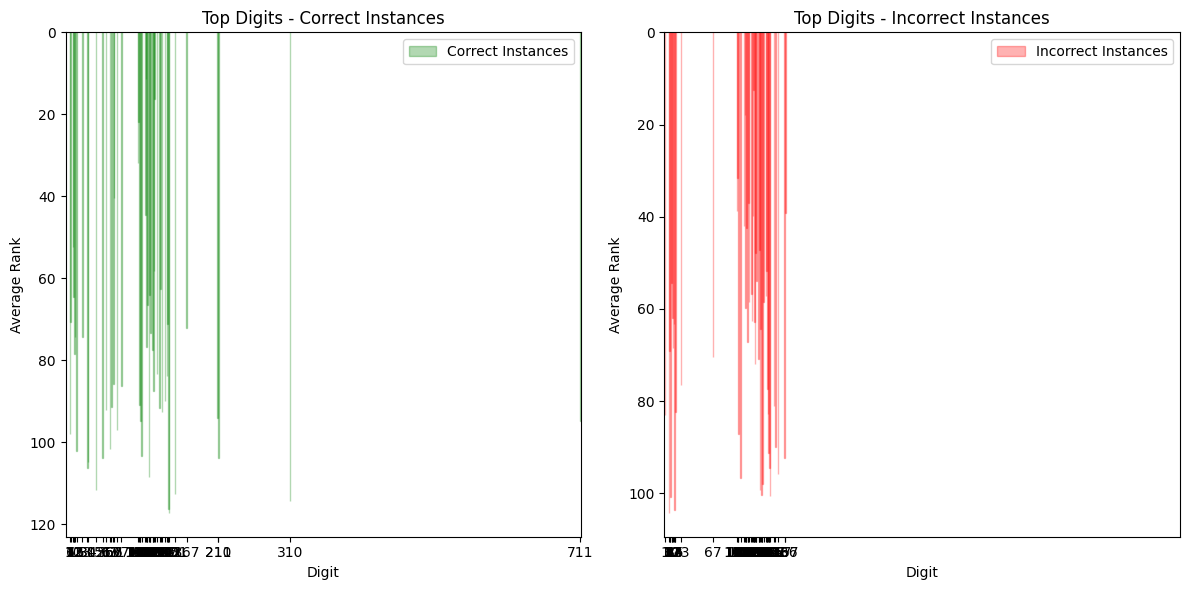

In [51]:
import matplotlib.pyplot as plt
import torch

# Get the top 30 indices for each category
top = 50
top_30_all_indices = layer_avg_ranks_all_indices[:top]
top_30_correct_indices = layer_avg_ranks_correct_indices[:top]
top_30_incorrect_indices = layer_avg_ranks_incorrect_indices[:top]

# Decode the digits and get their average ranks
top_30_all_digits = [int(tokenizer.decode(digit_token_indices[idx])) for idx in top_30_all_indices]
top_30_all_ranks = [layer_avg_ranks_all_sorted[i].item() for i in range(top)]
top_30_correct_digits = [int(tokenizer.decode(digit_token_indices[idx])) for idx in top_30_correct_indices]
top_30_correct_ranks = [layer_avg_ranks_correct_sorted[i].item() for i in range(top)]
top_30_incorrect_digits = [int(tokenizer.decode(digit_token_indices[idx])) for idx in top_30_incorrect_indices]
top_30_incorrect_ranks = [layer_avg_ranks_incorrect_sorted[i].item() for i in range(top)]

# Determine the x-axis range
min_digit = min(top_30_all_digits + top_30_correct_digits + top_30_incorrect_digits)
max_digit = max(top_30_all_digits + top_30_correct_digits + top_30_incorrect_digits)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot correct instances in first subplot
ax1.bar(top_30_correct_digits, top_30_correct_ranks, color='green', alpha=0.3, edgecolor='green', label='Correct Instances')
ax1.set_title('Top Digits - Correct Instances')
ax1.set_xlabel('Digit')
ax1.set_ylabel('Average Rank')
ax1.set_xlim(min_digit - 1, max_digit + 1)
ax1.invert_yaxis()  # Lower rank (better) should be at the top
ax1.legend()
unique_digits_correct = sorted(set(top_30_correct_digits))
ax1.set_xticks(unique_digits_correct)

# Plot incorrect instances in second subplot
ax2.bar(top_30_incorrect_digits, top_30_incorrect_ranks, color='red', alpha=0.3, edgecolor='red', label='Incorrect Instances')
ax2.set_title('Top Digits - Incorrect Instances')
ax2.set_xlabel('Digit')
ax2.set_ylabel('Average Rank')
ax2.set_xlim(min_digit - 1, max_digit + 1)
ax2.invert_yaxis()  # Lower rank (better) should be at the top
ax2.legend()
unique_digits_incorrect = sorted(set(top_30_incorrect_digits))
ax2.set_xticks(unique_digits_incorrect)

plt.tight_layout()
plt.show()

In [24]:
# Initialize a dictionary to store rank sums and counts for each token
# Get the average rank for across all instances for each token for layer 31
layer_31_ranks = layer_ranks[31][0]["ranks_all_instances"]
# Get the average rank across all instances (dim 0) for each token (dim 1)
layer_31_avg_ranks = layer_31_ranks.float().mean(dim=0)

# Sort the average ranks, but keep track of the original index
layer_31_avg_ranks_sorted, layer_31_avg_ranks_indices = torch.sort(layer_31_avg_ranks, dim=-1, descending=False)

# Print the top 10 tokens with the lowest average rank
print("Top 10 tokens with lowest average rank:")
for i in range(30):
    print(f"Digit {tokenizer.decode(digit_token_indices[layer_31_avg_ranks_indices[i].item()])}: average rank {layer_31_avg_ranks_sorted[i].item():.2f}")

Top 10 tokens with lowest average rank:
Digit 1: average rank 8.35
Digit 100: average rank 13.09
Digit 101: average rank 16.93
Digit 123: average rank 18.99
Digit 111: average rank 19.50
Digit 7: average rank 24.71
Digit 3: average rank 25.06
Digit 2: average rank 25.30
Digit 10: average rank 25.38
Digit 11: average rank 27.14
Digit 12: average rank 27.46
Digit 110: average rank 29.06
Digit 13: average rank 29.52
Digit 8: average rank 37.58
Digit 4: average rank 41.35
Digit 5: average rank 41.78
Digit 103: average rank 41.94
Digit 6: average rank 42.44
Digit 14: average rank 44.03
Digit 15: average rank 44.55
Digit 120: average rank 46.62
Digit 102: average rank 48.07
Digit 0: average rank 49.35
Digit 16: average rank 49.51
Digit 121: average rank 50.09
Digit 112: average rank 50.14
Digit 127: average rank 55.26
Digit 131: average rank 55.31
Digit 107: average rank 55.42
Digit 124: average rank 57.53


In [23]:
# Initialize a dictionary to store rank sums and counts for each token
# Get the average rank for across all instances for each token for layer 31
layer_31_ranks = layer_ranks[31][0]["ranks_incorrect_instances"]
# Get the average rank across all instances (dim 0) for each token (dim 1)
layer_31_avg_ranks = layer_31_ranks.float().mean(dim=0)

# Sort the average ranks, but keep track of the original index
layer_31_avg_ranks_sorted, layer_31_avg_ranks_indices = torch.sort(layer_31_avg_ranks, dim=-1, descending=False)

# Print the top 10 tokens with the lowest average rank
print("Top 10 tokens with lowest average rank:")
for i in range(30):
    print(f"Digit {tokenizer.decode(digit_token_indices[layer_31_avg_ranks_indices[i].item()])}: average rank {layer_31_avg_ranks_sorted[i].item():.2f}")

Top 10 tokens with lowest average rank:
Digit 1: average rank 7.73
Digit 100: average rank 13.20
Digit 101: average rank 17.27
Digit 123: average rank 18.10
Digit 111: average rank 19.16
Digit 2: average rank 24.40
Digit 7: average rank 24.42
Digit 3: average rank 25.11
Digit 10: average rank 25.25
Digit 11: average rank 26.33
Digit 12: average rank 26.74
Digit 13: average rank 28.94
Digit 110: average rank 29.21
Digit 8: average rank 36.27
Digit 4: average rank 41.19
Digit 5: average rank 41.64
Digit 103: average rank 41.73
Digit 6: average rank 42.46
Digit 14: average rank 43.08
Digit 15: average rank 43.58
Digit 120: average rank 45.36
Digit 102: average rank 47.65
Digit 112: average rank 48.11
Digit 121: average rank 48.32
Digit 0: average rank 48.60
Digit 16: average rank 48.80
Digit 127: average rank 51.32
Digit 131: average rank 53.18
Digit 124: average rank 53.53
Digit 113: average rank 54.88


In [22]:
print(correct_token_ranks_per_layer[31])
print(correct_ans_correct_token_ranks_per_layer[31])
print(incorrect_ans_correct_token_ranks_per_layer[31])

print(real_world_token_ranks_per_layer[31])
print(correct_ans_real_world_token_ranks_per_layer[31])
print(incorrect_ans_real_world_token_ranks_per_layer[31])



IndexError: list index out of range

In [ ]:
# PCA analysis to distinguish correct vs incorrect activations - not very separable relationship in first two prinicpal components for base 8
from sklearn.decomposition import PCA

# Choose a layer to analyze (e.g. layer 30)

for layer_to_analyze in range(32):
    print(f"Processing layer {layer_to_analyze}...")
    activations = layer_activation_dict[layer_to_analyze]

    # Split activations into correct and incorrect instances
    correct_activations = activations[correct_mask]
    incorrect_activations = activations[incorrect_mask]

    # Combine for PCA fitting
    all_activations = np.vstack([correct_activations, incorrect_activations])

    # Fit and transform PCA
    pca = PCA(n_components=2)
    activations_2d = pca.fit_transform(all_activations)

    # Split back into correct/incorrect
    n_correct = len(correct_activations)
    correct_2d = activations_2d[:n_correct]
    incorrect_2d = activations_2d[n_correct:]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(correct_2d[:, 0], correct_2d[:, 1], c='blue', label='Correct', alpha=0.5)
    plt.scatter(incorrect_2d[:, 0], incorrect_2d[:, 1], c='red', label='Incorrect', alpha=0.5)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component') 
    plt.title(f'PCA of Layer {layer_to_analyze} Activations\nCorrect vs Incorrect Instances')
    plt.legend()
    plt.show()

    # Print explained variance ratio
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


In [188]:
# # Average the probabilities over the instances for each layer
# # Select all digit tokens:
# digit_tokens = [str(i) for i in range(1000)]
# digit_mask = torch.tensor([tokenizer.encode(token, add_special_tokens=False)[0] for token in digit_tokens])
# expr_labels = prepare_dataset_labels(base, tokenizer)

# # Initialize storage for metrics across layers
# layer_metrics = {
#     'correct_probs': [],
#     'rw_probs': [], 
#     'other_probs': [],
#     'correct_ranks': [],
#     'rw_ranks': [],
#     'digit_probs': [] # Store full probability distribution over digits
# }

# for layer in range(32):
#     print(f"Processing layer {layer}...")
#     activations_path = f"./base{base}/layer{layer}/residuals.pt"
#     if not os.path.exists(activations_path):
#         print(f"Warning: Activations file not found for {base} at {activations_path}")
#         continue

#     # Load activations and get probabilities in one batch
#     activations = torch.load(activations_path).squeeze(1).to(model.device)
#     probs = logit_lens(model, activations)
    
#     # Get probabilities only for digit tokens
#     digit_probs = probs[:, digit_mask]
    
#     # Get token IDs for correct and rw tokens
#     batch_indices = torch.arange(len(expr_labels))
#     correct_token_ids = torch.tensor([label["token_ids"][0] for label in expr_labels])
#     rw_token_ids = torch.tensor([label["rw_token_ids"][0] for label in expr_labels])
    
#     # Find positions of correct and rw tokens in digit vocabulary
#     correct_digit_positions = torch.where(digit_mask == correct_token_ids[:, None])[1]
#     rw_digit_positions = torch.where(digit_mask == rw_token_ids[:, None])[1]
    
#     # Create a mask for each instance marking which digits are neither correct nor real-world
#     all_other_digits_mask = torch.ones_like(digit_probs, dtype=torch.bool)
    
#     # For each instance, mark the correct and real-world digits as False in the mask
#     for i in range(len(expr_labels)):
#         all_other_digits_mask[i, correct_digit_positions[i]] = False
#         all_other_digits_mask[i, rw_digit_positions[i]] = False
    
#     # Get probabilities for correct, real-world, and all other digits
#     correct_probs = torch.tensor([digit_probs[i, correct_digit_positions[i]] for i in range(len(expr_labels))])
#     rw_probs = torch.tensor([digit_probs[i, rw_digit_positions[i]] for i in range(len(expr_labels))])
    
#     # Calculate average probability of all other digits for each instance
#     other_digits_avg_probs = torch.zeros(len(expr_labels))
#     for i in range(len(expr_labels)):
#         other_digits_avg_probs[i] = digit_probs[i][all_other_digits_mask[i]].mean()
    
#     # Store average probabilities
#     layer_metrics['correct_probs'].append(correct_probs.mean().item())
#     layer_metrics['rw_probs'].append(rw_probs.mean().item())
#     layer_metrics['other_probs'].append(other_digits_avg_probs.mean().item())
    
#     # Store full probability distribution over digits (averaged across instances)
#     layer_metrics['digit_probs'].append(digit_probs.mean(dim=0).cpu())
    
#     # Sorting digit probabilities for ranking
#     digit_probs_sorted, digit_indices = torch.sort(digit_probs, dim=-1, descending=True)
    
#     # Get ranks
#     correct_ranks = torch.where(digit_indices == correct_digit_positions[:, None])[1] + 1
#     rw_ranks = torch.where(digit_indices == rw_digit_positions[:, None])[1] + 1
    
#     # Store average ranks
#     layer_metrics['correct_ranks'].append(correct_ranks.float().mean().item())
#     layer_metrics['rw_ranks'].append(rw_ranks.float().mean().item())

#     print(f"\nLayer {layer} metrics:")
#     print(f"Average probability of correct token: {layer_metrics['correct_probs'][-1]:.6f}")
#     print(f"Average probability of real world token: {layer_metrics['rw_probs'][-1]:.6f}")
#     print(f"Average probability of all other digit tokens: {layer_metrics['other_probs'][-1]:.6f}")
#     print(f"Average correct token rank: {layer_metrics['correct_ranks'][-1]:.2f} (out of 1000)")
#     print(f"Average real world token rank: {layer_metrics['rw_ranks'][-1]:.2f} (out of 1000)")

# # Create subplot with 3 plots
# plt.figure(figsize=(15, 5))

# # Plot 1: Token probabilities
# plt.subplot(1, 3, 1)
# plt.plot(range(32), layer_metrics['correct_probs'], label='Correct Token')
# plt.plot(range(32), layer_metrics['rw_probs'], label='Real World Token')
# plt.plot(range(32), layer_metrics['other_probs'], label='Other Digits')
# plt.xlabel('Layer')
# plt.ylabel('Average Probability')
# plt.title('Token Probabilities Across Layers')
# plt.legend()

# # Plot 2: Token ranks
# plt.subplot(1, 3, 2)
# plt.plot(range(32), layer_metrics['correct_ranks'], label='Correct Token')
# plt.plot(range(32), layer_metrics['rw_ranks'], label='Real World Token')
# plt.xlabel('Layer')
# plt.ylabel('Average Rank')
# plt.title('Token Ranks Across Layers')
# plt.legend()

# # Plot 3: Probability distribution over digits for selected layers
# plt.subplot(1, 3, 3)
# selected_layers = [0, 15, 31]  # Beginning, middle, end
# for layer in selected_layers:
#     plt.plot(range(1000), layer_metrics['digit_probs'][layer], label=f'Layer {layer}', alpha=0.7)
# plt.xlabel('Digit Value')
# plt.ylabel('Average Probability')
# plt.title('Probability Distribution\nover Digits')
# plt.legend()

# plt.tight_layout()
# plt.show()



Processing layer 0...

Layer 0 metrics:
Average probability of correct token: 0.000002
Average probability of real world token: 0.000002
Average probability of all other digit tokens: 0.000001
Average correct token rank: 401.73 (out of 1000)
Average real world token rank: 401.73 (out of 1000)
Processing layer 1...

Layer 1 metrics:
Average probability of correct token: 0.000001
Average probability of real world token: 0.000001
Average probability of all other digit tokens: 0.000002
Average correct token rank: 523.75 (out of 1000)
Average real world token rank: 523.75 (out of 1000)
Processing layer 2...

Layer 2 metrics:
Average probability of correct token: 0.000000
Average probability of real world token: 0.000000
Average probability of all other digit tokens: 0.000001
Average correct token rank: 559.53 (out of 1000)
Average real world token rank: 559.53 (out of 1000)
Processing layer 3...

Layer 3 metrics:
Average probability of correct token: 0.000001
Average probability of real wor

: 

In [70]:
# base = 10
# layer = 31
# expr_labels = prepare_dataset_labels(base, tokenizer)
# # Get the activations for the layer
# activations_path = f"./base{base}/layer{layer}/residuals.pt"
# activations = torch.load(activations_path).squeeze(1).to(model.device)

# # Get the probabilities for the correct token
# probs = logit_lens(model, activations)
# correct_token_ids = torch.tensor([label["token_ids"][0] for label in expr_labels])
# rw_token_ids = torch.tensor([label["rw_token_ids"][0] for label in expr_labels])



# # Get the digit tokens
# digit_tokens = [str(i) for i in range(1000)]
# digit_mask = torch.tensor([tokenizer.encode(token, add_special_tokens=False)[0] for token in digit_tokens])



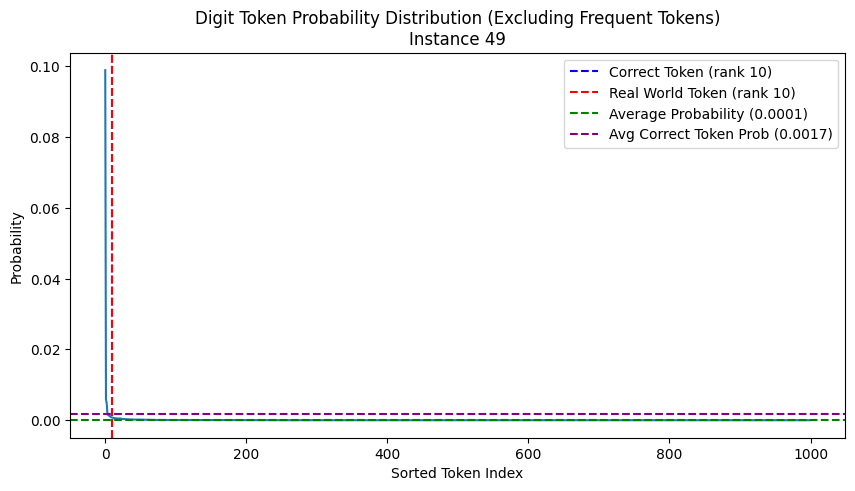

Correct token: 118
Real world token: 118

Top 10 tokens (excluding frequent tokens):
1. Token: 33, Probability: 0.09891
2. Token: 38, Probability: 0.00588
3. Token: 3, Probability: 0.00487
4. Token: 83, Probability: 0.00209
5. Token: 34, Probability: 0.00149
6. Token: 43, Probability: 0.00144
7. Token: 18, Probability: 0.00118
8. Token: 32, Probability: 0.00113
9. Token: 103, Probability: 0.00086
10. Token: 37, Probability: 0.00083


In [71]:
# # Get frequent token IDs to exclude
# # frequent_token_ids = [token_id for _, token_id, _ in frequent_tokens]

# # Randomly sample one instance
# idx = torch.randint(0, len(probs), (1,)).item()
# instance_probs = probs[idx]
# correct_token = correct_token_ids[idx].item()
# rw_token = rw_token_ids[idx].item()

# # Get probabilities for digit tokens for this instance, excluding frequent tokens
# #digit_mask_filtered = torch.tensor([token_id for token_id in digit_mask if token_id not in frequent_token_ids])
# instance_digit_probs = instance_probs[digit_mask]

# # Plot the digit token probability distribution (ordered by probability from highest to lowest)
# plt.figure(figsize=(10, 5))
# probs_sorted, indices = instance_digit_probs.detach().cpu().sort(descending=True)
# plt.plot(range(len(digit_mask)), probs_sorted)

# # Add vertical lines for correct and real world tokens if they're not in frequent tokens
# correct_token_prob = instance_probs[correct_token].item()
# rw_token_prob = instance_probs[rw_token].item()

# # Find positions of correct and RW tokens in sorted order if they exist in filtered mask
# if correct_token in digit_mask:
#     correct_pos = (indices == digit_mask.tolist().index(correct_token)).nonzero().item()
#     plt.axvline(x=correct_pos, color='blue', linestyle='--', label=f'Correct Token (rank {correct_pos})')

# if rw_token in digit_mask:
#     rw_pos = (indices == digit_mask.tolist().index(rw_token)).nonzero().item()
#     plt.axvline(x=rw_pos, color='red', linestyle='--', label=f'Real World Token (rank {rw_pos})')

# # Calculate and plot average probabilities
# avg_prob = probs_sorted.mean().item()
# plt.axhline(y=avg_prob, color='green', linestyle='--', label=f'Average Probability ({avg_prob:.4f})')

# # # Calculate average probability for correct tokens, excluding frequent tokens
# filtered_correct_probs = probs[:,correct_token_ids]
# avg_correct_prob = filtered_correct_probs.mean().item() if len(filtered_correct_probs) > 0 else 0
# plt.axhline(y=avg_correct_prob, color='purple', linestyle='--', label=f'Avg Correct Token Prob ({avg_correct_prob:.4f})')

# plt.xlabel('Sorted Token Index')
# plt.ylabel('Probability')
# plt.title(f'Digit Token Probability Distribution (Excluding Frequent Tokens)\nInstance {idx}')
# plt.legend()
# plt.show()

# # Print correct and real world token strings
# print(f"Correct token: {tokenizer.decode(correct_token)}")
# print(f"Real world token: {tokenizer.decode(rw_token)}")

# # Print top 10 tokens
# print("\nTop 10 tokens (excluding frequent tokens):")
# for i in range(min(10, len(indices))):
#     token_idx = indices[i].item()
#     token_id = digit_mask[token_idx].item()
#     token_prob = probs_sorted[i].item()
#     token_str = tokenizer.decode(token_id)
#     print(f"{i+1}. Token: {token_str}, Probability: {token_prob:.5f}")


In [158]:
# # Count occurrences of each token in top 10
# token_counts = {}
# token_ids = {}
# for instance_idx in range(len(probs)):
#     instance_probs = probs[instance_idx]
#     instance_digit_probs = instance_probs[digit_mask]
#     _, indices = instance_digit_probs.detach().cpu().sort(descending=True)
#     top_10 = indices[:100].tolist()
    
#     for token_idx in top_10:
#         token_id = digit_mask[token_idx].item()
#         token_str = tokenizer.decode(token_id)
#         if token_str not in token_counts:
#             token_counts[token_str] = 0
#             token_ids[token_str] = token_id
#         token_counts[token_str] += 1

# # Get tokens that appear in more than half the instances
# total_instances = len(probs)
# threshold = total_instances / 2
# frequent_tokens = []

# for token_str, count in token_counts.items():
#     if count > threshold:
#         frequent_tokens.append((token_str, token_ids[token_str], count))

# # Print frequent tokens and their IDs
# print("\nTokens appearing in top 10 more than 50% of the time:")
# for token_str, token_id, count in frequent_tokens:
#     print(f"Token: {token_str}, ID: {token_id}, Count: {count}/{total_instances}")


Tokens appearing in top 10 more than 50% of the time:
Token: 112, ID: 7261, Count: 1000/1000
Token: 906, ID: 22224, Count: 1000/1000
Token: 466, ID: 21404, Count: 1000/1000
Token: 76, ID: 4767, Count: 1000/1000
Token: 110, ID: 5120, Count: 1000/1000
Token: 219, ID: 13762, Count: 1000/1000
Token: 211, ID: 11483, Count: 1000/1000
Token: 119, ID: 9079, Count: 1000/1000
Token: 687, ID: 21897, Count: 1000/1000
Token: 189, ID: 9378, Count: 1000/1000
Token: 106, ID: 7461, Count: 1000/1000
Token: 789, ID: 16474, Count: 1000/1000
Token: 371, ID: 18650, Count: 1000/1000
Token: 71, ID: 6028, Count: 1000/1000
Token: 234, ID: 11727, Count: 1000/1000
Token: 719, ID: 24758, Count: 1000/1000
Token: 190, ID: 7028, Count: 1000/1000
Token: 297, ID: 18163, Count: 1000/1000
Token: 245, ID: 13078, Count: 1000/1000
Token: 507, ID: 20068, Count: 1000/1000
Token: 121, ID: 7994, Count: 1000/1000
Token: 686, ID: 22347, Count: 1000/1000
Token: 625, ID: 15894, Count: 1000/1000
Token: 231, ID: 12245, Count: 1000/1

In [23]:
# # Print the token ID and value of the digit with highest probability
# highest_prob_idx = indices[0].item()
# highest_prob_token = digit_mask[highest_prob_idx].item()
# print(f"Token ID of digit with highest probability: {highest_prob_token} (digit value: {digit_tokens[highest_prob_idx]})")

# # Decode the token to string
# highest_prob_token_str = tokenizer.decode(highest_prob_token)
# print(f"Token string: {highest_prob_token_str}")



Token ID of digit with highest probability: 22224 (digit value: 906)
Token string: 906


In [ ]:
# # Plot the average probability for correct predictions only
# plot_all = True
# if not plot_all:
#     correct_indices = json.load(open(f"./base{base}/indices.json"))['correct']

# correct_probs = []
# rw_probs = []
# random_probs = []

# for layer_probs in results.values():
#     if not plot_all:
#         correct_mask = torch.zeros(len(layer_probs["correct_token_probs"]), dtype=torch.bool)
#         correct_mask[correct_indices] = True
#     else:
#         correct_mask = torch.ones(len(layer_probs["correct_token_probs"]), dtype=torch.bool)

#     if correct_mask.any():
#         # Calculate mean probability only for correct predictions
        
#         layer_mean_rw = torch.tensor(layer_probs['rw_token_probs'])[correct_mask.bool()].mean().item()
#         rw_probs.append(layer_mean_rw)

#         layer_mean = torch.tensor(layer_probs['correct_token_probs'])[correct_mask.bool()].mean().item()
#         correct_probs.append(layer_mean)

#         layer_mean_random = torch.tensor(layer_probs['random_number_token_probs'])[correct_mask.bool()].mean().item()   
#         random_probs.append(layer_mean_random)
    

# plt.figure(figsize=(10, 5))
# plt.plot(range(32), correct_probs)
# plt.plot(range(32), rw_probs)
# plt.plot(range(32), random_probs)
# plt.xlabel('Layer')
# plt.ylabel('Average Probability (Correct Predictions)')
# plt.legend(['Correct', 'Real World', 'random_number'])
# plt.title(f'Average Probability for Correct Predictions in Base {base}')
# plt.show()